In [1]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
import subprocess
import whisper
import csv
import ffmpeg


/tmp/ipykernel_295750/4111553420.py:25: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(name, sr=None)
/home/dhyan/FullFight/venv/lib/python3.10/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


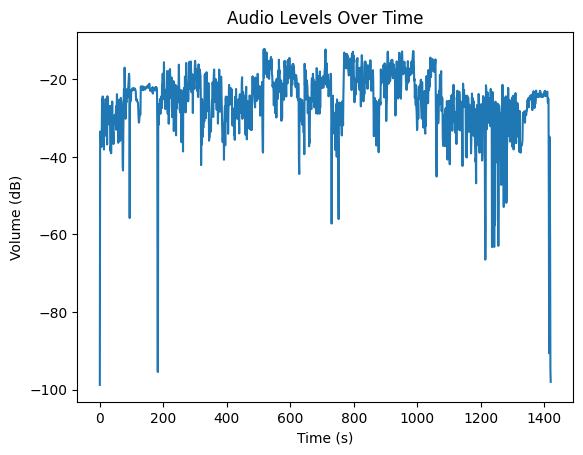

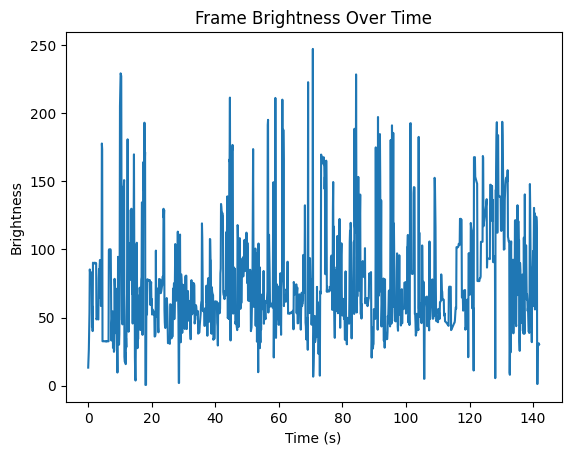

In [ ]:
def get_video(name):
    return "uploads/'" + name + "'"

def plot_time(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

frame_dir = "frames"
os.makedirs(frame_dir, exist_ok=True)

def extract_frames(name):
    output_pattern = os.path.join(frame_dir, f"{os.path.basename(name)}_frame_%04d.png")

    ffmpeg.input(name) \
        .output(output_pattern, vf='fps=1') \
        .overwrite_output() \
        .run()


def save_audio_rms_to_csv(name, csv_filename=None, plot=False):
    y, sr = librosa.load(name, sr=None)
    frame_length = int(sr * 1)  # 100ms frames
    hop_length = frame_length

    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    times = librosa.frames_to_time(range(len(rms)), sr=sr, hop_length=hop_length)
    
    if plot:
        plot_time(times, 20 * np.log10(rms), xlabel="Time (s)", ylabel="Volume (dB)", title="Audio Levels Over Time")
    
    if csv_filename is not None:
        with open(csv_filename, mode='w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Time (s)", "RMS"])
            for t, r in zip(times, rms):
                writer.writerow([t, r])


# Save frame brightness to CSV only if a filename is explicitly provided
def save_frame_brightness_to_csv(name, csv_filename=None, plot=False):
    brightness_data = []
    if csv_filename is None:
        for fname in sorted(os.listdir(frame_dir)):
            if fname.endswith(".png"):
                img = cv2.imread(os.path.join(frame_dir, fname))
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                brightness = np.mean(gray)
                brightness_data.append(brightness)
                
            timestamps = [i * 1 for i in range(len(brightness_data))]

        return brightness_data, timestamps

    for fname in sorted(os.listdir(frame_dir)):
        if fname.endswith(".png"):
            img = cv2.imread(os.path.join(frame_dir, fname))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)
            brightness_data.append(brightness)

    timestamps = [i * 0.1 for i in range(len(brightness_data))]
    with open(csv_filename, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Time (s)", "Brightness"])
        for t, b in zip(timestamps, brightness_data):
            writer.writerow([t, b])
            
    if plot:
        plot_time(timestamps, brightness_data, xlabel="Time (s)", ylabel="Brightness", title="Frame Brightness Over Time")

# Example usage:
# extract_frames("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv")
save_audio_rms_to_csv("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv", csv_filename="audio_rms.csv", plot=True)
save_frame_brightness_to_csv("uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv", csv_filename="frame_brightness.csv", plot=True)


In [5]:
# Dialouge detection and anger detection
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import datetime
import csv
import whisper

input_video = "uploads/[Kayoanime] Solo Leveling - S02E06 (1).mkv"
output_audio = "audio.wav"
anger_threshold = 0.3
merge_gap = 3
csv_filename = "angry_sections.csv"

# Extract audio: 16kHz mono WAV (required for Whisper)
{
    ffmpeg
    .input(input_video)
    .output(
        output_audio,
        format='s16le',  # raw signed 16-bit little-endian PCM
        acodec='pcm_s16le',
        ar=16000,        # 16 kHz sampling rate
        ac=1             # mono
    )
    .overwrite_output()  # equivalent to -y
    .run()
}

# Whipser model
model = whisper.load_model("base")  # change model size when tuning
result = model.transcribe(input_video)

print("Loading emotion classifier...")
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
emotion_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
labels = ['anger', 'joy', 'optimism', 'sadness']

# Angry per segment
angry_segments = []

for seg in result["segments"]:

    text = seg["text"]
    start = seg["start"]
    end = seg["end"]

    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    with torch.no_grad():
        logits = emotion_model(**inputs).logits
        probs = F.softmax(logits, dim=1)[0]

    anger_score = probs[labels.index("anger")].item()

    if anger_score > anger_threshold:
        angry_segments.append({
            "start": start,
            "end": end,
            "text": text.strip(),
            "anger_score": anger_score
        })

# Group angry segmenet
grouped_angry_sections = []

if angry_segments:
    current_group = [angry_segments[0]]
    for seg in angry_segments[1:]:
        prev = current_group[-1]
        if seg['start'] - prev['end'] <= merge_gap:
            current_group.append(seg)
        else:
            grouped_angry_sections.append(current_group)
            current_group = [seg]
    grouped_angry_sections.append(current_group)

# Rank groups and print
def sec_to_mmss(sec):
    return str(datetime.timedelta(seconds=int(sec)))

ranked_sections = []

for group in grouped_angry_sections:
    start = group[0]['start']
    end = group[-1]['end']
    avg_anger = sum(s['anger_score'] for s in group) / len(group)
    ranked_sections.append({
        "start": start,
        "end": end,
        "avg_anger": avg_anger,
        "segments": group
    })

# Sort by avg anger desc
ranked_sections.sort(key=lambda x: x["avg_anger"], reverse=True)

# Print full grouped anger sections
print("\nAngriest Sections in the Video:\n")
for i, section in enumerate(ranked_sections[:5]):  # Get top 5 section, hopefully enough?
    print(f"🔴 Section {i+1}")
    print(f"[{sec_to_mmss(section['start'])} → {sec_to_mmss(section['end'])}] | Avg Anger Score: {section['avg_anger']:.2f}\n")

    for seg in section["segments"]:
        print(f"  🕒 [{sec_to_mmss(seg['start'])} → {sec_to_mmss(seg['end'])}] | Anger: {seg['anger_score']:.2f}")
        print(f"  🗣️  {seg['text']}\n")

    print("------------------------------------------------------------\n")

with open(csv_filename, mode='w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "Section Number",
        "Section Start",
        "Section End",
        "Section Avg Anger",
        "Segment Start",
        "Segment End",
        "Segment Anger Score",
        "Segment Text"
    ])

    for i, section in enumerate(ranked_sections[:5], start=1):
        section_start = sec_to_mmss(section["start"])
        section_end = sec_to_mmss(section["end"])
        avg_anger = f"{section['avg_anger']:.2f}"

        for seg in section["segments"]:
            seg_start = sec_to_mmss(seg["start"])
            seg_end = sec_to_mmss(seg["end"])
            seg_anger = f"{seg['anger_score']:.2f}"
            seg_text = seg["text"].replace('\n', ' ').strip()
            writer.writerow([
                i,
                section_start,
                section_end,
                avg_anger,
                seg_start,
                seg_end,
                seg_anger,
                seg_text
            ])

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Loading emotion classifier...


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



Angriest Sections in the Video:

🔴 Section 1
[0:15:24 → 0:15:29] | Avg Anger Score: 0.97

  🕒 [0:15:24 → 0:15:29] | Anger: 0.97
  🗣️  To this filthy ride to my decaracal gang, I'm no match for you!

------------------------------------------------------------

🔴 Section 2
[0:15:02 → 0:15:04] | Avg Anger Score: 0.97

  🕒 [0:15:02 → 0:15:04] | Anger: 0.97
  🗣️  That move kind of pisses me off.

------------------------------------------------------------

🔴 Section 3
[0:13:59 → 0:14:02] | Avg Anger Score: 0.95

  🕒 [0:13:59 → 0:14:02] | Anger: 0.95
  🗣️  All right, man, I'm gonna break that annoying shield of yours.

------------------------------------------------------------

🔴 Section 4
[0:04:45 → 0:04:55] | Avg Anger Score: 0.95

  🕒 [0:04:45 → 0:04:55] | Anger: 0.95
  🗣️  You fool, anti-gravel

------------------------------------------------------------

🔴 Section 5
[0:05:00 → 0:05:03] | Avg Anger Score: 0.94

  🕒 [0:05:00 → 0:05:03] | Anger: 0.94
  🗣️  Got you! No!

-------------

In [ ]:

# Merge dialogue, audio RMS, and frame brightness CSVs by timestamp

import pandas as pd

# Load CSVs
dialogue_df = pd.read_csv("angry_sections.csv")  # or your dialogue csv
audio_df = pd.read_csv("audio_rms.csv")
brightness_df = pd.read_csv("frame_brightness.csv")

# Prepare audio and brightness for merging (round timestamps for alignment)
audio_df["Time (s)"] = audio_df["Time (s)"].round(1)
brightness_df["Time (s)"] = brightness_df["Time (s)"].round(1)

# Merge audio and brightness on timestamp 
merged_df = pd.merge(audio_df, brightness_df, on="Time (s)", how="outer")

# If dialogue has timestamps, merge them as well (example assumes Segment Start/End in seconds)
# You may need to adjust this part based on your dialogue CSV format
if "Segment Start" in dialogue_df.columns:
    # Convert Segment Start to seconds if needed
    def mmss_to_sec(mmss):
        try:
            parts = str(mmss).split(':')
            return int(parts[0]) * 60 + int(parts[1])
        except:
            return None
    dialogue_df["Start_sec"] = dialogue_df["Segment Start"].apply(mmss_to_sec)
    # Round to nearest 0.1s for alignment
    dialogue_df["Start_sec"] = dialogue_df["Start_sec"].round(1)
    # Merge dialogue info into merged_df
    merged_df = pd.merge(merged_df, dialogue_df, left_on="Time (s)", right_on="Start_sec", how="left")

# Save merged CSV
merged_df.to_csv("merged_features.csv", index=False)
print("Merged CSV saved as merged_features.csv")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged features
df = pd.read_csv("merged_features.csv")

# Plot Audio RMS and Brightness over time
plt.figure(figsize=(15,5))
plt.plot(df["Time (s)"], df["RMS"], label="Audio RMS")
plt.plot(df["Time (s)"], df["Brightness"], label="Frame Brightness")
plt.xlabel("Time (s)")
plt.ylabel("Value")
plt.title("Audio RMS and Frame Brightness Over Time")
plt.legend()
plt.show()

# If you have anger scores or dialogue, plot those too
if "Segment Anger Score" in df.columns:
    plt.figure(figsize=(15,5))
    plt.plot(df["Time (s)"], df["Segment Anger Score"], label="Anger Score", color='red')
    plt.xlabel("Time (s)")
    plt.ylabel("Anger Score")
    plt.title("Dialogue Anger Score Over Time")
    plt.legend()
    plt.show()